## Paavo Reinikka, 589479

### Lab exercise #4

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

from gpflow import set_trainable
from gpflow.utilities import to_default_float, positive


gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")

# for reproducibility of this notebook:
np.random.seed(123)


In [2]:
#import warnings
#warnings.filterwarnings(action='ignore')

## Convolutional likelihood models.

In [3]:
import scipy.integrate as integrate
##https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html##

np.random.seed(111)

n = 100
magnSigma2 = .5
ell = .5
sigma2 = 0.001
x = np.linspace(-2,2,n)

f =  lambda t: np.exp(-(2*t)**2)

def g(t):
    bool1 = t > -0.5
    bool2 = t < 0.5 
    return bool1*bool2*1


<ipython-input-4-d6c36ec1f8dc>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda t,tau: f(t)*g(t-tau),-np.inf,np.inf,input)[0]


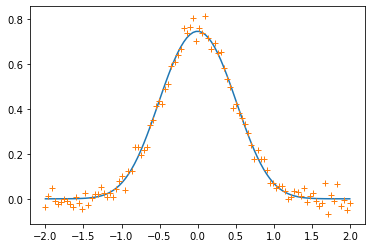

In [4]:
# we now sample noisy data from the convolution function
def convol(input):
    return integrate.quad(lambda t,tau: f(t)*g(t-tau),-np.inf,np.inf,input)[0]

f_conv=np.vectorize(convol)(x)

y = f_conv + np.sqrt(sigma2)*np.random.normal(size=100);
plt.plot(x,f_conv)
plt.plot(x,y,'+');
plt.show()

## Task 1a: Use the scipy numerical integration function to compute the convolution.
-  plot g, f and f_conv.


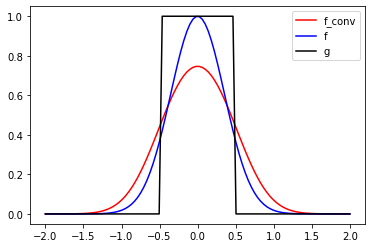

In [5]:
plt.plot(x,f_conv,'r')
plt.plot(x,f(x),'b')
plt.plot(x,g(x),'k')
plt.legend(['f_conv','f','g'])

## Task 1b: Compute a discrete convolution.
- Use the discrete grid (x) as above and turn the integral in to a sum. (writing this out on paper may help)
- Output a Convolution matrix which acts as the linear operator on the vector f, $f_{conv} = Cf $. 
- Plot the convolved f together with the discrete version.

In [6]:
#This works for symmetric taps/filter, assuming there is zeros (/padding) on both ends
def linear_operator(taps, dx):
    '''
    The idea for (1-sided) filter:
    
        | g(0)  g(1)  g(2) |   |f(0)|
        |       g(0)  g(1) | X |f(1)|
        |             g(0) |   |f(2)|
        
        This gives "right" half of the convolution,
        and the left is just it's transpose. Assuming
        zero padding, we can just "mirror" the matrix
        over the horizontal centerline.
    '''
    n=len(taps)
    C = np.zeros((n,n))
    C[0,:] = taps
    for i in range(1,n):
        C[i,i:] = taps[:-i]
    Cup=np.split(C.T,2)[1]
    Cdown=np.split(C,2)[0]
    
    return dx*np.vstack((Cup,Cdown))


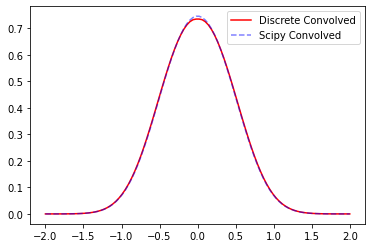

In [7]:
dx=x[-1]-x[-2]
C = linear_operator(g(x),dx)
testi = C @ f(x)
plt.plot(x,testi,'r')
plt.plot(x,f_conv,'b--',alpha=.5)
plt.legend(['Discrete Convolved','Scipy Convolved'])
plt.show()

## Task 1c: Now solve the deconvolution problem.
- Follow the adjusted GP regression formula's from the lecture slides using an SE kernel and the C you have calculated.
- Plot the true underlying function alongside with the mean and 95% confidence interval, as shown on slide 30.

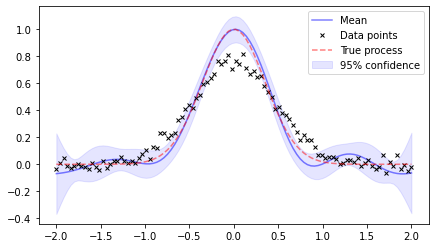

In [8]:
def generate_mvn_samples(mu, Sigma, M):    
    jitter = 1e-8
    D = len(mu)
    L = np.linalg.cholesky(Sigma + jitter*np.identity(D))
    zs = np.random.normal(0, 1, size=(D, M)) # samples standard Gaussian, and...
    fs = mu + np.dot(L, zs) # mean shifts by mu and scales/rotates with Chol
    return fs

def SE_kernel(X1, X2, alpha=1, scale=1):
    
    a = -1./(2*scale**2)
    return alpha * np.exp(a * ( -2*X1@X2.T \
                        + np.sum(X1**2,axis=1, keepdims=True)\
                        + np.sum(X2**2,1)))

xt=x

K_ff= C @ SE_kernel(x[:,None],x[:,None],magnSigma2,ell) @ C.T
K_fxf=SE_kernel(xt[:,None],x[:,None],magnSigma2,ell) @ C.T
K_fxfx=SE_kernel(xt[:,None],xt[:,None],magnSigma2,ell)

#Ki = np.linalg.inv(K_ff + sigma2*np.identity(K_ff.shape[0]))
L = np.linalg.cholesky(K_ff + sigma2*np.identity(K_ff.shape[0]))
v = np.linalg.solve(L,K_fxf.T)
w = np.linalg.solve(L,y)


mu = v.T @ w # K_fxf @ Ki @ y
S = K_fxfx - v.T @ v  # K_fxfx - K_fxf @ Ki @ K_fxf.T

plt.figure(figsize=[7,4])
#plt.plot(xt, generate_mvn_samples(mu[:,None],S,20),'b',alpha=.1)
plt.plot(xt,mu,'b',alpha=.5)
plt.plot(x,y,'kx',markersize=4)
plt.plot(x,f(x),'r--',alpha=.5)
plt.fill_between(xt,mu+2*np.sqrt(np.diag(S)),\
                 mu-2*np.sqrt(np.diag(S)),\
                 color='blue',alpha=.1)
plt.legend(['Mean','Data points','True process','95% confidence'])
plt.show()

## Convolutional kernel.

We follow the example https://gpflow.readthedocs.io/en/master/notebooks/advanced/convolutional.html

In [9]:
# for reproducibility of this notebook:
np.random.seed(123)
tf.random.set_seed(42)

def make_rectangle(arr, x0, y0, x1, y1):
    # Draw the edges
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    # Randomnly initialise the corners
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    # Generate the rectangle dataset
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries to ensure 
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (
        d.reshape(num, w * h).astype(gpflow.config.default_float()),
        Y.astype(gpflow.config.default_float()),
    )

In [10]:
MAXITER = 100
NUM_TRAIN_DATA = 100
NUM_TEST_DATA = 300

H = W = 14  # width and height of the images.
IMAGE_SHAPE = [H, W]

X, Y = data = make_rectangles_dataset(NUM_TRAIN_DATA, *IMAGE_SHAPE)
Xt, Yt = test_data = make_rectangles_dataset(NUM_TEST_DATA, *IMAGE_SHAPE)

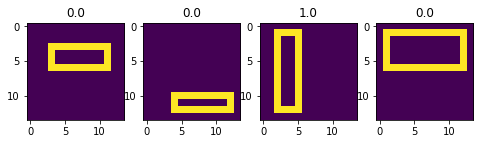

In [11]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(*IMAGE_SHAPE))
    plt.title(Y[i, 0])

Each image contains the outline of a randomly generated rectangle, and is labelled according
to whether the rectangle has larger width or height. $y_i = 1$ if height is greater than width and $y_i = 0$ if width is greater than height.

## Task 2a: Comment on why a standard kernel would struggle with the rectangle dataset?

It is unlikely there is a smooth mapping from pixel space to labels. Using standard kernels in the pixel space fail to capture the relevant structure. E.g., SE, or other isotropic kernels are oblivious to the true explanatory relation, that is the weight/height relation (probably more easily modelled as frequency content). Normal kernels would also need to learn non-local structure in a very high-dimensional pixel space, while using simple similarities (like Euclidean) which are not fully meaningful to the problem at hand. 

*This could probably also be tackled with standard kernels, if we were to learn somekind of an embedding (likely with convolutions) before training the GP model. 

We now try to fit a squared exponential kernel to the rectangle dataset, using the model class SVGP. SVGP is the sparse version of VGP discussed in lecture 4.

In [12]:
# This is a standard initialisation of the SVGP model class we need a kernel, 
# likelihood and inducing point locations.
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X.copy()),
)# We use our data points as inducing points but usually you would want to use a sparse set.

In [13]:
# We turn off training for inducing point locations
set_trainable(rbf_m.inducing_variable, False)

# Similar to how we optimised in lab_3 but now using Adam and gradients are called inside optimizer.
def run_adam(model, iterations, data): 
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(data, compile=True)
    optimizer = tf.optimizers.Adam(lr=0.01)

    @tf.function # This creates a static graph so we can reuse it every iteration.
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf


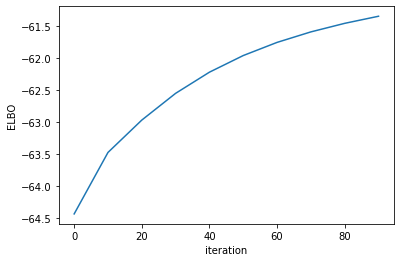

In [29]:
maxiter = 100

logf = run_adam(rbf_m, maxiter,(X,Y))
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [30]:
train_acc = np.mean((rbf_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")

Train acc: 99.0%
Test acc : 68.66666666666667%


In [34]:
gpflow.utilities.print_summary(rbf_m) # We can here see all the parameters that we optimise

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.4075966364174084
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.6120739522850895
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(100, 196)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[-0.45862765...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[7.54127189e-01, 0.00000000e+00, 0.00000000e+00..."


## Task 2b: Change the number of inducing points in this model?

Currently we are not using a reduced number inducing points $M =N$ and SVGP is the same as VGP. Try picking less but keep them randomnly selected from the data and see the effect on the model. Try $M=75,50,25$ and state the train and test accuracy.

**Using different number of inducing points:**

In [32]:
ind = np.random.choice(np.arange(X.shape[0]),size=75,replace=False)
X_M75=X.copy()[ind,:]
ind = np.random.choice(np.arange(X.shape[0]),size=50,replace=False)
X_M50=X.copy()[ind,:]
ind = np.random.choice(np.arange(X.shape[0]),size=25,replace=False)
X_M25=X.copy()[ind,:]

rbf_m75 = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X_M75),
)

rbf_m50 = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X_M50),
)

rbf_m25 = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X_M25),
)

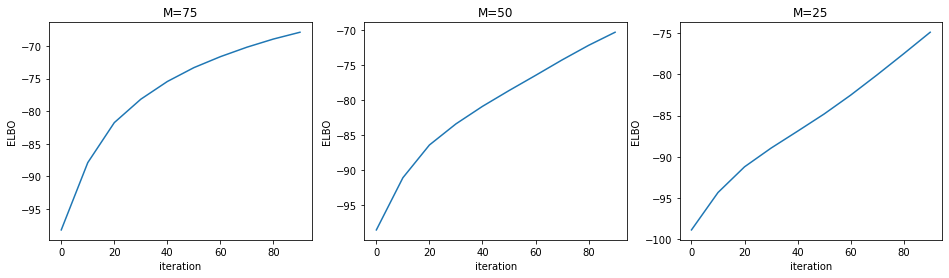

In [33]:
maxiter = 100

logf75 = run_adam(rbf_m75, maxiter,(X,Y))
plt.figure(figsize=[16,4])
plt.subplot(1,3,1)
plt.plot(np.arange(maxiter)[::10], logf75)
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.title('M=75')

plt.subplot(1,3,2)
logf50 = run_adam(rbf_m50, maxiter,(X,Y))
plt.plot(np.arange(maxiter)[::10], logf50)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")
plt.title('M=50')

plt.subplot(1,3,3)
logf25 = run_adam(rbf_m25, maxiter,(X,Y))
plt.plot(np.arange(maxiter)[::10], logf25)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")
plt.title('M=25')
plt.show()


In [35]:
train_acc = np.mean((rbf_m75.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((rbf_m75.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"M=75:\nTrain acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")

train_acc = np.mean((rbf_m50.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((rbf_m50.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"\nM=50\nTrain acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")

train_acc = np.mean((rbf_m25.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((rbf_m25.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"\nM=25\nTrain acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")

M=75:
Train acc: 94.0%
Test acc : 70.0%

M=50
Train acc: 91.0%
Test acc : 69.33333333333334%

M=25
Train acc: 92.0%
Test acc : 69.0%


## Convolutional Kernel
To construct a convolutional GP we use a patch response function $g: \mathbb{R}^E \to \mathbb{R}$ mapping form patch size $E$ to a real value. Then we make the overall function of the image $f: \mathbb{R}^D \to \mathbb{R}$ a sum of the patch functions. If $g(.)$ is given a GP prior then a GP prior is induced on $f(.)$.

$$ g \sim \mathcal{GP}(0,k_g(\bf{z},\bf{z}')), \quad f ({x}) = \sum_{p} g(\bf{x}^{[p]}) $$

$$ f ({x}) \sim \mathcal{GP} \big(0,\sum_{p} \sum_{p'} k_g(\bf{x}^{[p]},\bf{x}'^{[p']}) \big)$$

- The kernel now works on the patches.
- $k_g$ can be any base kernel but we will use the squared exponential

In [36]:
def get_patches(X): # A function that will give us vector patches
        """
        Extracts patches from the images X.
        :param X: (N x input_dim)
        :return: Patches (N, num_patches, patch_shape)
        """

        num_data = tf.shape(X)[0]
        castX = tf.transpose(tf.reshape(X, [num_data, -1, 1]), [0, 2, 1])
        patches = tf.image.extract_patches(
            tf.reshape(castX, [-1, 14, 14, 1], name="rX"),
            [1, 3, 3, 1],
            [1, 1, 1, 1],
            [1, 1, 1, 1],
            "VALID",
        )
        shp = tf.shape(patches)  # img x out_rows x out_cols
        reshaped_patches = tf.reshape(
            patches, [num_data, 1 * shp[1] * shp[2], shp[3]]
        )
        return to_default_float(reshaped_patches)

## Task 2c: Compute a value of the kernel and compare it against the gpflow implementation.

- Do not compute the whole kernel simply K[0,0] will do. Remember to normalise by the total number of sums.
- You can check your solution against the evaluated GPflow kernel.
- Comment on the computation of the convolutional kernel against a standard kernel.

In [ ]:
base = gpflow.kernels.SquaredExponential()
Xp = get_patches(X)
patch_shape = [3, 3]

'''
k_11 = 0
for i in range(144):
    for j in range(144):
        k_11 += base(Xp[0,i,:],Xp[0,j,:])/ 144**2.0
        
'''

conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), IMAGE_SHAPE, patch_shape)
kc = conv_k(X)
kc[0,0]


<tf.Tensor: shape=(), dtype=float64, numpy=0.46453751180605296>

**NOTE: I'm not sure if this (above) solution was meant to be here, so here is mine just to be sure:**

In [ ]:
first_sample=Xp[0,:,:]
print(f"Kernel over the patches of the first sample: {np.sum(base(first_sample,first_sample))/144**2}")
print(f"gpflow conv kernel K[0,0]: {kc[0,0]}")

Kernel over the patches of the first sample: 0.4645375118060716
gpflow conv kernel K[0,0]: 0.46453751180605296


Constructing the kernel this way enables the covariance to capture meaningful structure. Using convolutional kernel (filter) allows aggregating around each pairs proximity (i.e., learning local structure, and invariance). Computationally this is more expensive.



Now we build the SVGP model with the convolution kernel.

In [39]:
## We constrain our parameters to help with optimisation.
f64 = lambda x: np.array(x, dtype=np.float64)
positive_with_min = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4))(tfp.bijectors.Softplus())
constrained = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4), scale=f64(100.0))(
    tfp.bijectors.Sigmoid()
)
max_abs_1 = lambda: tfp.bijectors.AffineScalar(shift=f64(-2.0), scale=f64(4.0))(
    tfp.bijectors.Sigmoid()
)

# Build the convolutional kernel given specific image data.
conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), IMAGE_SHAPE, patch_shape)
conv_k.base_kernel.lengthscales = gpflow.Parameter(1.0, transform=positive_with_min())

# Weight scale and variance are non-identifiable. We also need to prevent variance from shooting off crazily.
conv_k.base_kernel.variance = gpflow.Parameter(1.0, transform=constrained())
conv_k.weights = gpflow.Parameter(conv_k.weights.numpy(), transform=max_abs_1())
conv_f = gpflow.inducing_variables.InducingPatches(
    np.unique(conv_k.get_patches(X).numpy().reshape(-1, 9), axis=0)
) # We place the inducing variables in the patch space and remove duplicates.


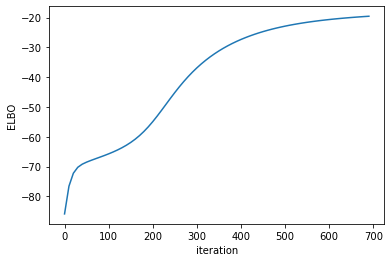

In [40]:
maxiter = 700

# we now define a new model with the special convolutional kernel structure.
conv_m = gpflow.models.SVGP(conv_k, gpflow.likelihoods.Bernoulli(), conv_f)

set_trainable(conv_m.inducing_variable, False) # for not do not train inducing variables.
set_trainable(conv_m.kernel.base_kernel.variance, True)
set_trainable(conv_m.kernel.weights, True)


logf = run_adam(conv_m, maxiter,(X,Y))
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [41]:
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")


Train acc: 100.0%
Test acc : 98.33333333333333%


In [42]:
gpflow.utilities.print_summary(conv_m) # can you spot the difference with the standard SVGP summary.

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.base_kernel.variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,62.71137727265235
SVGP.kernel.base_kernel.lengthscales,Parameter,Softplus + AffineScalar,,True,(),float64,0.6426671135007894
SVGP.kernel.weights,Parameter,Sigmoid + AffineScalar,,True,"(144,)",float64,"[-0.77944789, -0.37365567, -0.2530622..."
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(45, 9)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(45, 1)",float64,[[0.03312427...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 45, 45)",float64,"[[[0.07696406, 0., 0...."


## Task 2d: Now turn training on for the patches and plot them

**I pasted the definitions here, so I could better experiment using different initializations:** 

In [43]:
# Build the convolutional kernel given specific image data.
conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), IMAGE_SHAPE, patch_shape)
conv_k.base_kernel.lengthscales = gpflow.Parameter(1.0, transform=positive_with_min())

# Weight scale and variance are non-identifiable. We also need to prevent variance from shooting off crazily.
conv_k.base_kernel.variance = gpflow.Parameter(1.0, transform=constrained())
conv_k.weights = gpflow.Parameter(conv_k.weights.numpy(), transform=max_abs_1())
conv_f = gpflow.inducing_variables.InducingPatches(
    np.unique(conv_k.get_patches(X).numpy().reshape(-1, 9), axis=0)
) # We place the inducing variables in the patch space and remove duplicates.


In [44]:
conv_m_inOn = gpflow.models.SVGP(conv_k, gpflow.likelihoods.Bernoulli(), conv_f)

set_trainable(conv_m_inOn.inducing_variable, True) # for not do not train inducing variables.
set_trainable(conv_m_inOn.kernel.base_kernel.variance, True)
set_trainable(conv_m_inOn.kernel.weights, True)


logf_inOn = run_adam(conv_m_inOn, maxiter,(X,Y))

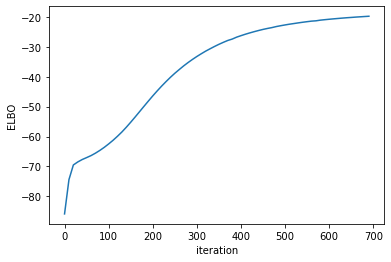

Train acc: 100.0%
Test acc : 98.0%


In [45]:
plt.plot(np.arange(maxiter)[::10], logf_inOn)
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.show()

train_acc_inOn = np.mean((conv_m_inOn.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc_inOn = np.mean((conv_m_inOn.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc_inOn * 100}%\nTest acc : {test_acc_inOn*100}%")

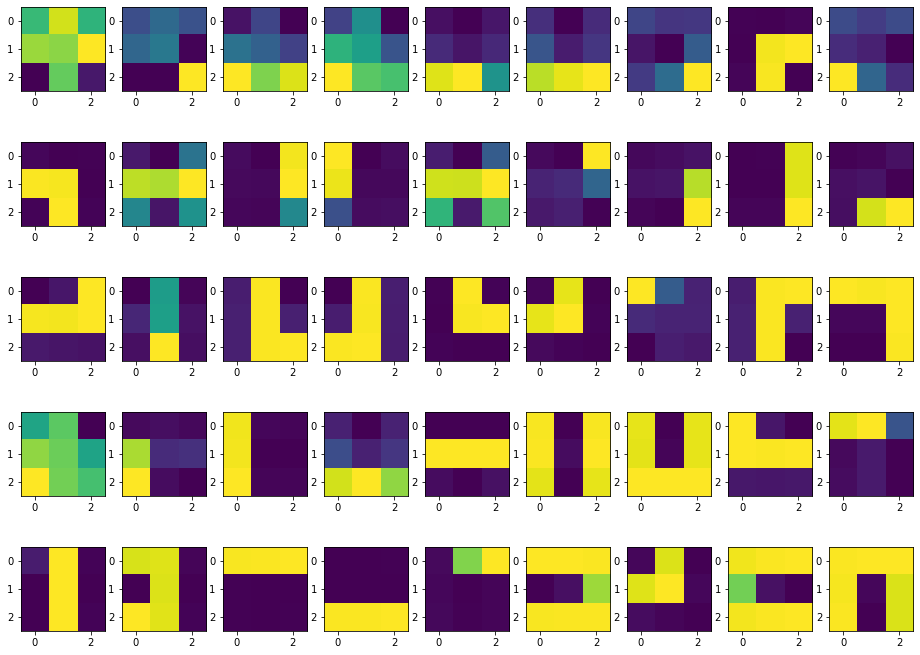

In [46]:
foo = lambda i: plt.imshow(conv_m_inOn.inducing_variable.Z.numpy()[i,:].reshape(3,3))
plt.figure(figsize=[16,12])
for i in range(5):
    for j in range(9):
        plt.subplot(5,9,i*9 + j + 1)
        foo(i*9 + j)

# Sprectal mixture kernel

The SM kernel implementation compatible with gpflow. There are several kernels already defined in gpflow.kernels, and they all share the base 'Kernel' class. The kernel computation uses tensorflow functions (not numpy) so that we can utilize autodiff for later optimization.

__Task 3a__: Complete the below SM kernel function to implement 1D Spectral Mixture kernel within the gpflow framework

$$k(x,x') = \sum_{q=1}^Q a_q \exp( -2 \pi^2 \sigma_q^2 \tau^2) \cos( 2 \pi \mu_q \tau), \quad \tau = x-x'$$

that corresponds to a spectral mixture density

$$S(\omega) = \sum_{q=1}^Q a_q \mathcal{N}(\omega | \mu_q, \sigma_q^2)$$

where $a_q$ is the amplitude, $\mu_q$ is the mean frequency and $\sigma_q^2$ is the frequency variance in the frequency $\omega$ domain. For info on implementing gpflow kernels, see https://gpflow.readthedocs.io/en/master/notebooks/tailor/kernel_design.html


Hint: Compute the component-wise kernels into a kernel matrix of size (N,N,Q), and sum them together to obtain (N,N) kernel matrix.

In [ ]:

class UnivariateSMkernel(gpflow.kernels.Kernel):
    """
    The spectral mixture (SM) kernel function [Wilson et al 2013]
    
    Inherits the 'Kernel' class from gpflow.kernels
     o We need to override the constructor to include the parameters (a,mu,sigma)
     o We need to override the 'K' function to compute the exp*cos kernel
     o We need to override the 'K_diag' function
     
    Supports only 1D inputs. Wilson et al 2014 contains multivariate version of the kernel 
    """
    
    def __init__(self, amps=None, freqs=None, ells=None, Q=1):
        """
        - 'amps' are the amplitudes of the mixture components 
        - 'freqs' are the frequencies means of the mixture components 
        - 'ells' are the frequency stdevs of the mixture components 
        - 'Q' is the number of components
        """
        
        # init as 1D kernel 
        super().__init__(active_dims=[0]) #input_dim=1

        # mixture amplitudes
        if amps is None:
            amps = np.random.uniform(0,1,Q)
        self.amplitudes = gpflow.Parameter(amps, transform=positive())
        
        # frequency means
        if freqs is None:
            freqs = np.random.uniform(0,1,Q)
        self.frequencies = gpflow.Parameter(freqs, transform=positive())
        
        # frequency variances
        if ells is None:
            ells = np.random.uniform(0,1,Q)
        self.lengthscales = gpflow.Parameter(ells, transform=positive())
        
    def K_diag(self, X):
        return tf.fill(tf.stack([tf.shape(X)[0]]), tf.reduce_sum(self.amplitudes))
    
    def K(self, X1, X2=None):
        """ Returns a kernel matrix of size (N1,N2) where (i,j)'th element is k(xi,xj)
        
        Input: X1 of size (N1,D)
               X2 of size (N2,D)
        """
        if X2 is None:
            X2 = X1
        
        sigma2_q = self.lengthscales**2
        mu_q = self.frequencies
        a_q = self.amplitudes
        
        tau = X1 - tf.transpose(X2)
        tau2 = tau**2
        sigTau=sigma2_q[:,None,None]*tau2[None,:,:]
        
        exp_term = tf.math.exp(-2.0*(np.pi**2)*sigTau)
        cos_term = tf.math.cos(2.0*np.pi*mu_q[:,None,None]*tau[None,:,:])
        batch = exp_term*cos_term
        kernel = tf.reduce_sum(a_q[:,None,None]*batch,0)
        
        return kernel
        #return tf.dtypes.cast(kernel,X1.dtype)
    
    

__Task 3b__: Fit a trigonometric function using the code below with both Gaussian and SM kernel.

* Why are the fits different outside the training data?

* Which kernel fits the data better, and why?


**Spectral mixture manages to capture periodicity (fequency content/information of the data), and can therefore also leverage that presumably non-local structure further outside the training set. In case of trigonometric function (known ground truth for us), SM can be expected to fit the data better. The "frequency domain" lengthscales still quarantee that the posterior mean eventually decays back towards the prior (zero), but the model clearly remains somewhat confident beyond the Gaussian alternative. Having 3 mixture components allows the covariance to model possibly 3 different frequencies (including zero frequency, i.e., constant trend), as well as decay. It has more degrees of freedom, and more flexibility (also higher dimensional optimization topology), while it still accounts for uncertainty, like any other GP/Bayesian model (integrates uncertainty, which somewhat impedes overfitting).**

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.82905
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.117581
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00574529


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.amplitudes,Parameter,Softplus,,True,"(3,)",float64,[9.03179569e+00 2.06427826e-24 1.25460277e+00]
GPR.kernel.frequencies,Parameter,Softplus,,True,"(3,)",float64,[1.83335421e-06 1.24255537e-01 2.81414399e+00]
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[8.58370272e-10 2.10479593e+00 5.74199037e-01]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.005337753547590039


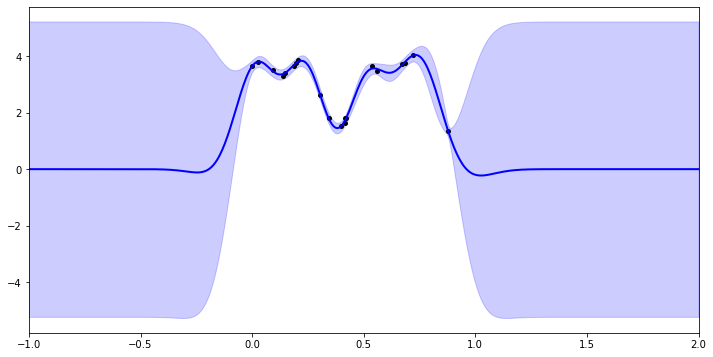

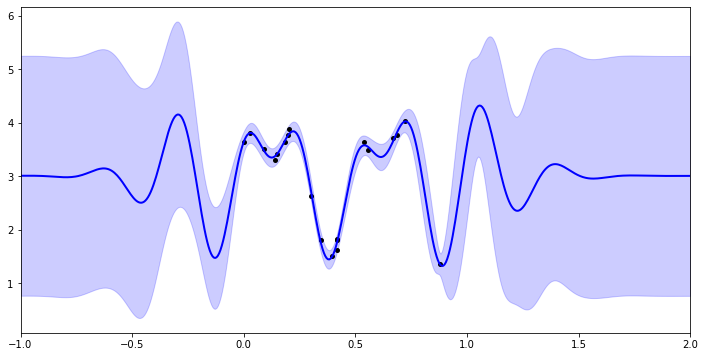

In [60]:
# plotting function    
def plotgp(m, X, y, minx, maxx):
    xx = np.linspace(minx, maxx, 500)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'k.', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(minx, maxx)


opt = gpflow.optimizers.Scipy()

# data
np.random.seed(1)
N = 20
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3

# fit GP fit Gaussian kernel
kgauss = gpflow.kernels.RBF( 1, lengthscales=0.3 )  # init lengthscale to 0.3
mg = gpflow.models.GPR( (X,Y), kernel = kgauss )
mg.likelihood.variance.assign(0.01)
opt.minimize(mg.training_loss, variables=mg.trainable_variables)

# print and plot
gpflow.utilities.print_summary(mg)
plotgp(mg, X, Y, -1, 2)


# fit GP with SM kernel
ksm = UnivariateSMkernel( Q = 3 )
ms = gpflow.models.GPR( (X,Y), kernel = ksm )
ms.likelihood.variance.assign(0.01)
opt.minimize(ms.training_loss, variables=ms.trainable_variables)

# print and plot
gpflow.utilities.print_summary(ms)
plotgp(ms, X, Y, -1, 2)


__Task 3c__ Apply the SM kernel to the CO2 dataset. Below is a template code that (usually) fits the datasets correctly due to initialising the correct 1-year frequency (1/12) for the model. It might take a few retries to find a good fit.

* Modify the code to have a random initialisation of the frequencies. Can you still learn the 1-year frequency if the initialisation is random? Why or whynot?

* Modify the visualisation to include both training and test points. Is the fit reasonable?

* Visualise the optimised SM kernel matrix. What can you see?

* Visualise the spectral density $S(\omega) = \sum_{q=1}^Q a_q \mathcal{N}(\omega | \mu_q, \sigma_q^2)$ using the parameter you just optimised. 



**NOTE (OLD - I got different results for the default init): I am pretty sure my kernel is correct, but with this initialization, the model does not find the 1 year pattern. There might be some difference with random.seed on linux/windows systems(?, I'm on linux). In any case, I do fit the data with some repeats below (after these first plots).**

**SOLVED: Yes, there was some difference with the way my linux python config. handled the pandas dataframes. I'm now returning this after running it on windows, which required me to change (below) the load_mauna_loa_... -function: I changed the reads y = ml_data.data[:,0] to ml_data.data.iloc[:,0], and same for y. Now I get the same default results as others.**

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.amplitudes,Parameter,Softplus,,True,"(3,)",float64,[1.01160828e+05 7.15205648e+00 1.46208002e+02]
GPR.kernel.frequencies,Parameter,Softplus,,True,"(3,)",float64,[0. 0.51682771 0. ]
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.00000000e+00 6.05642873e-01 6.37148257e-29]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.1


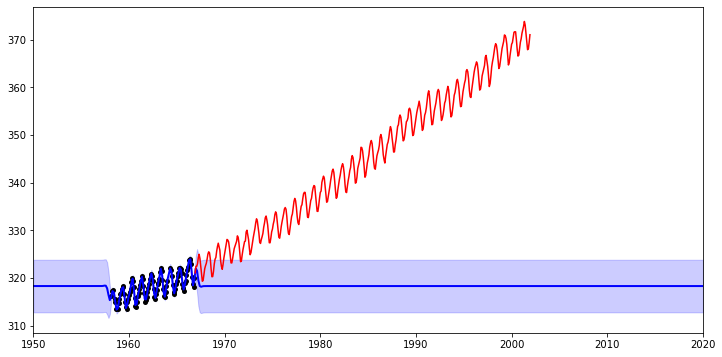

In [67]:
import sklearn
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data.iloc[:, 0]
    m = ml_data.data.iloc[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    avg_ppmvs = np.asarray(avg_ppmvs).reshape(-1, 1)
    return months, avg_ppmvs


X,Y = load_mauna_loa_atmospheric_co2()

Xtr = X[0:100]
Ytr = Y[0:100]

Xts = X[100:]
Yts = Y[100:]


# set SM kernel model
ksm = UnivariateSMkernel( Q = 3, freqs = [0.083, 1.0, 0.5], ells = [0.01, 0.01, 0.01], amps = [20,20,20] )
#ksm = UnivariateSMkernel( Q = 10 )
m = gpflow.models.GPR( (Xtr,Ytr), kernel = ksm )
m.likelihood.variance.assign(0.1)
set_trainable(m.likelihood.variance, False)


# optimize
opt = gpflow.optimizers.Scipy( )
opt.minimize( m.training_loss, variables=m.trainable_variables )

# print
gpflow.utilities.print_summary(m)

# plot
plotgp(m, Xtr, Ytr, 1950., 2020.)
plt.plot(Xts,Yts,'r')

**The covariance structure shows repeating/periodic pattern.There is a slight indication that something interesting may be present in the data, in addition to constant trend and periodicity (see the small irregularity at the lower right quadrant in the kernel image). That will become more clear with a better fit, and after looking more data.**

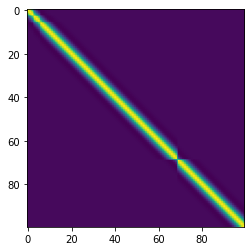

In [68]:
plt.imshow(m.kernel.K(Xtr,Xtr))

**Random initialization:**


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.amplitudes,Parameter,Softplus,,True,"(3,)",float64,[0.00000000e+00 3.51041395e+00 1.01776009e+05]
GPR.kernel.frequencies,Parameter,Softplus,,True,"(3,)",float64,[1936.69495039 0. 0. ]
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[2.57247700e+03 2.67097266e+04 3.20961892e-04]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.1


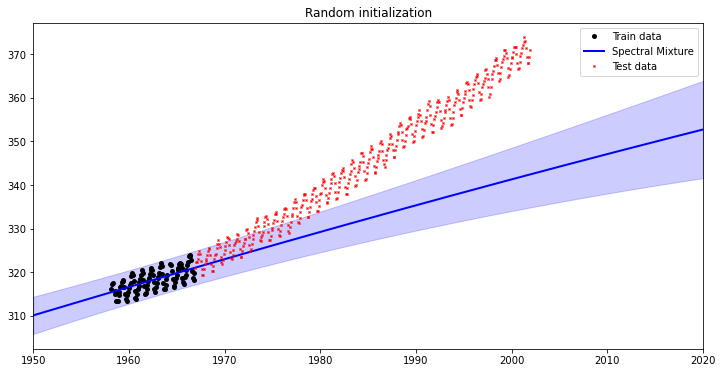

In [54]:
# set SM kernel model
np.random.seed(5)
ksm_rand = UnivariateSMkernel( Q = 3, freqs = np.random.rand(3), ells = [0.01, 0.01, 0.01], amps = [20,20,20] )

m_rand = gpflow.models.GPR( (Xtr,Ytr), kernel = ksm_rand )
m_rand.likelihood.variance.assign(0.1)
set_trainable(m_rand.likelihood.variance, False)

# optimize
opt = gpflow.optimizers.Scipy()
opt.minimize( m_rand.training_loss, variables=m_rand.trainable_variables )

# print
gpflow.utilities.print_summary(m_rand)

# plot
plotgp(m_rand, Xtr, Ytr, 1950., 2020.)
plt.plot(Xts,Yts,'rx',markersize=2)
plt.legend(['Train data','Spectral Mixture','Test data'])
plt.title("Random initialization")
plt.show()

**Random initialization for lengthscales provides widely varying results. This plot shows the model failed to capture the periodicity, but got the trend almost correct. Images of the kernel do not show significant repeating structure, and a linear term is dominating (freq~0). In contrast to the previous fit, now the kernel is accounting for correlations over a wide distance (would correspond to a long lengthscale for a standard kernel), which mitigates the uncertainty outside the training set. There is some small scale variability (possibly very high frequency periodicity even), but it is almost unrecognizable due to small amplitude and high decay rate (you can still notice a sharp narrow diagonal in the kernel image, or by zooming the timeseries).**

**For the test set (kernel image) we see a very "stiff" (smooth, non-local) covariance; plenty of averaging, which somewhat mitigates the uncertainty, but makes the fit almosts a straight line (bends/decays very slowly towards the prior mean). Interestingly, the earlier inflection point is missing, which could indicate it has something to do with the periodicity (and that's why this model misses it)**

**Although the fit fails to capture the main frequency component, by getting the trend almost right on average this model would still provide better predictions for the test set. But in any case, it is not a good fit.**

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.amplitudes,Parameter,Softplus,,True,"(3,)",float64,[0.00000000e+00 3.51041395e+00 1.01776009e+05]
GPR.kernel.frequencies,Parameter,Softplus,,True,"(3,)",float64,[1936.69495039 0. 0. ]
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[2.57247700e+03 2.67097266e+04 3.20961892e-04]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.1


Text(0.5, 1.0, 'Randomized, test')

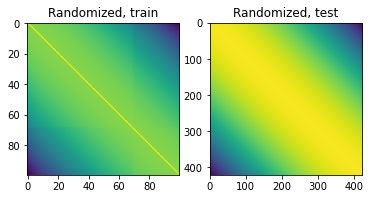

In [55]:
gpflow.utilities.print_summary(m_rand)
plt.subplot(1,2,1)
plt.imshow(m_rand.kernel(Xtr,Xtr))
plt.title("Randomized, train")
plt.subplot(1,2,2)
plt.imshow(m_rand.kernel(Xts,Xts))
plt.title("Randomized, test")

**Manually tuning the initialization:**

There are 3 different initializations commented. The last one tweaks not just frequencies, but the others as well. Uncomment for testing, **BUT THE FOLLOWING PLOTS AND EXPLANATIONS ARE FOR THIS CONFIGURATION**.

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.amplitudes,Parameter,Softplus,,True,"(3,)",float64,[8.00000000e+05 3.16610420e+00 3.89892596e-01]
GPR.kernel.frequencies,Parameter,Softplus,,True,"(3,)",float64,[8.23623065e-16 1.00278728e+00 8.74535567e-22]
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1.30656422e-04 1.20333873e-18 1.32888910e+00]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.1


Text(0.5, 1.0, 'Tweaked initialization')

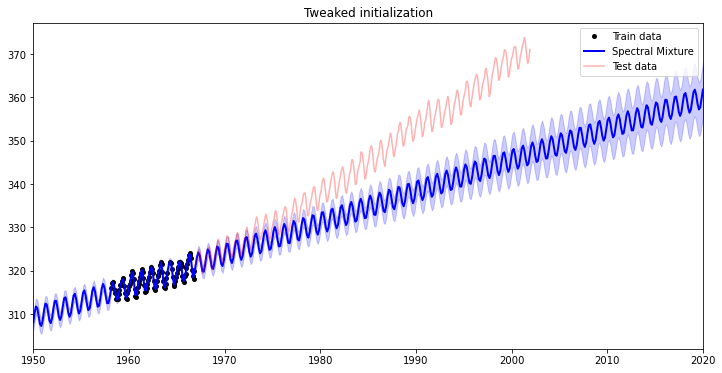

In [56]:
#OK
#ksm_man = UnivariateSMkernel( Q = 3, freqs = [0.083, 1.0, 0.5], ells = [0.01*2, 0.01, 0.01], amps = [20,20,20] )

#Good:
#ksm_man = UnivariateSMkernel( Q = 3, freqs = [0.001,1.0,0.1], ells = [0.01, 0.01, 0.01], amps = [20,20,20] )

#Better:
ksm_man = UnivariateSMkernel( Q = 3, freqs = [0.001,1.0,0.1], ells = [1e-4,0.0115,0.1], amps = [8e+5, 1.85, 10.21] )

m_man = gpflow.models.GPR( (Xtr,Ytr), kernel = ksm_man )
m_man.likelihood.variance.assign(0.1)
set_trainable(m_man.likelihood.variance, False)

# optimize
opt = gpflow.optimizers.Scipy()
opt.minimize( m_man.training_loss, variables=m_man.trainable_variables )

# print
gpflow.utilities.print_summary(m_man)

# plot
plotgp(m_man, Xtr, Ytr, 1950., 2020.)
plt.plot(Xts,Yts,'r',alpha=.3)
plt.legend(['Train data','Spectral Mixture','Test data'])
plt.title("Tweaked initialization")

**Plotting the kernel (Both, for training and test data):**

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.amplitudes,Parameter,Softplus,,True,"(3,)",float64,[8.00000000e+05 3.16610420e+00 3.89892596e-01]
GPR.kernel.frequencies,Parameter,Softplus,,True,"(3,)",float64,[8.23623065e-16 1.00278728e+00 8.74535567e-22]
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1.30656422e-04 1.20333873e-18 1.32888910e+00]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.1


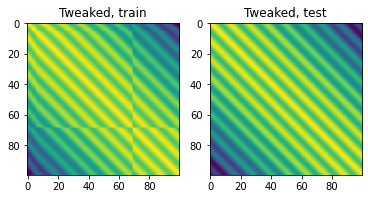

Text(0.5, 1.0, 'Tweaked, train-test')

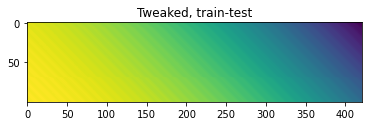

In [70]:
gpflow.utilities.print_summary(m_man)
plt.subplot(1,2,1)
plt.imshow(m_man.kernel(Xtr,Xtr))
plt.title("Tweaked, train")
plt.subplot(1,2,2)
plt.imshow(m_man.kernel(Xts[:100,:],Xts[:100,:]))
plt.title("Tweaked, test")
plt.show()
plt.imshow(m_man.kernel(Xtr,Xts))
plt.title("Tweaked, train-test")


**Now the periodicity is captured better, and it shows in the "waves" of the kernel images (the pattern remains, albeit weakened, even far beyond the training data). However, we can still see somekind of an inflection point (right bottom quadrant), where there is a phase-shift (these make forward prediction hard). The earlier plot for the test data also shows a shift in the trend, which is not present yet in the training set (this might explain why the model can't really capture the inflection/"turn".**

**NOTE:  The model I fitted only contains a constant trend (̃freq~ 0, no decay), and the yearly periodicity (feq~1). There is effectively no decay: lengthscales are close to zero, except for the third term, for which the amplitude is very small (that's why I'm using semilog).**

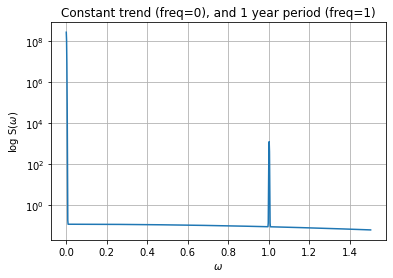

In [58]:
import scipy.stats as stats

mu_qs=m_man.kernel.frequencies.numpy()
sig_qs=m_man.kernel.lengthscales.numpy() + 1e-3
a_qs=m_man.kernel.amplitudes.numpy()

omega=np.linspace(0,1.5*np.max(mu_qs),1000)

S_omega = lambda x: a_qs[0]*stats.norm.pdf(x,mu_qs[0],sig_qs[0])+a_qs[1]*stats.norm.pdf(x,mu_qs[1],sig_qs[1])+a_qs[2]*stats.norm.pdf(x,mu_qs[2],sig_qs[2])
plt.semilogy(omega,S_omega(omega))
#plt.plot(omega,S_omega(omega))
plt.title("Constant trend (freq=0), and 1 year period (freq=1)")
plt.xlabel('$\omega$')
plt.ylabel('log S($\omega$)')
plt.grid()
plt.show()


### ------------------------------------------------------------------------------------------------------------------------------------------------------
Just to show more clearly the nature of the mixture components: Here I have scaled the dominating 1st component down (trend), and the near zero 3rd component up (for which there is uncertainty - probably includes much of the noise, see broad blue spectrum). 2nd mixture component also explains a descent amount of the data, i.e., the periodicity.

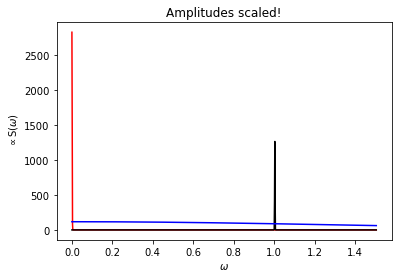

In [59]:
plt.plot(omega,1e-5*a_qs[0]*stats.norm.pdf(omega, mu_qs[0],sig_qs[0]),'r')
plt.plot(omega,a_qs[1]*stats.norm.pdf(omega, mu_qs[1],sig_qs[1]),'k')
plt.plot(omega,1000*a_qs[2]*stats.norm.pdf(omega, mu_qs[2],sig_qs[2]),'b')
plt.xlabel('$\omega$')
plt.ylabel(' $\propto$S($\omega$)')
plt.title("Amplitudes scaled!")
plt.show()